# Ensemble Models

A natural and tempting alternative is to **combine** several algorithms (or the predictions that result from them) to try to extract value out of each engine (or learner). This intention is not new and contributions towards this goal go back at least to Bates and Granger (1969).

Below we outline a few books on the topic of *ensembles*, or synonyms, such as **forecast aggregation, model averaging, mixture of experts or prediction combination**:
- Zhou (2012): a very didactic book that covers the main ideas of ensembles
- Schapire and Freund (2012): the main reference for boosting (and hence, ensembling) with many theoretical results and thus strong mathematical groundings;
- Seni and Elder (2010): an introduction dedicated to tree methods mainly;
- Claeskens and Hjort (2008): an overview of model selection techniques with a few chapters focused on model averaging;
- Zhang and Ma (2012): a collection of thematic chapters on ensemble learning;
- Okun et al. (2011): examples of applications of ensembles.

In this chapter, we cover the basic ideas and concepts behind the notion of ensembles. For deeper treatments, you may refer to the above books (indeed, random forests and boosted trees discussed in Chapter 6 are examples of ensembles).

## Linear Ensembles

### Principles

In this chapter we adopt the following notations. We work with 
- $M$ models where $\tilde{y}_{i,m}$ is the prediction of model $m$ for instance $i$ and 
- Errors $\epsilon_{i,m}=y_i-\tilde{y}_{i,m}$ are stacked into a $(I \times M)$ matrix $\textbf{E}$
- A linear combination of models has sample error equal to $\textbf{Ew}$, where $\textbf{w}=w_m$ are weights assigned to each model such that $\textbf{w}'\textbf{1}_M=1$.
- Minimize the total (squared) error is thus a simple quadratic program with unique constraint. The Lagrange function is $L(\textbf{w})=\textbf{w}'\textbf{E}'\textbf{Ew}-\lambda(\textbf{w}'\textbf{1}_M-1)$ and hence $$\frac{\partial}{\partial \textbf{w}}L(\textbf{w})=\textbf{E}'\textbf{E}\textbf{w}-\lambda \textbf{1}_M=0 \quad \Leftrightarrow \quad \textbf{w}=\lambda(\textbf{E}'\textbf{E})^{-1}\textbf{1}_M$$
and the constraint imposes that $$\textbf{w}^*=\frac{(\textbf{E}'\textbf{E})^{-1}\textbf{1}_M}{(\textbf{1}_M'\textbf{E}'\textbf{E})^{-1}\textbf{1}_M}$$ This form is similar to that of minimum variance portfolios. If errors are unbiased $(\textbf{1}_I'\textbf{E}=\textbf{0}_M')$, then $\textbf{E}'\textbf{E}$ is the covariance matrix of errors.

This expression shows an important feature of optimized linear ensembles: they can only add value *if the models tell different stories*. If two models are redundant, $\textbf{E}'\textbf{E}$ will be close to singular and $\textbf{w}^*$ will arbitrage one against the other in a spurious fashion. This is the exact same problem as when mean-variance portfolios are constituted with highly correlated assets: diversification will fail because when things go wrong, all assets go down.

In the limit when correlations increase to 1, the above formulation becomes highly unstable and ensembles cannot be trusted. One heuristic way to see this is when $M=2$ and
$$\textbf{E}'\textbf{E}=\left[
\begin{array}{cc} \sigma_1^2 & \rho\sigma_1\sigma_2 \\
\rho\sigma_1\sigma_2 & \sigma_2^2 \\
\end{array}
\right] \quad \Leftrightarrow  \quad 
(\textbf{E}'\textbf{E})^{-1}=\frac{1}{1-\rho^2}\left[
\begin{array}{cc} \sigma_1^{-2} & -\rho(\sigma_1\sigma_2)^{-1} \\
-\rho(\sigma_1\sigma_2)^{-1} & \sigma_2^{-2} \\
\end{array}
\right]$$
so that when $\rho \rightarrow 1$, the model with minimum $\sigma_i^2$ will see its weights towards *infinity* while the model model will have a similarly large **negative weight**: the model arbitrage between them. That seems like a very bad idea.

There is another illustration of the issues caused by correlations. Let’s assume we face $M$ correlated errors $\epsilon_m$ with pairwise correlation $\rho$, zero mean and variance $\sigma^2$. The variance of errors is 
\begin{align*}
\mathbb{E}\left[\frac{1}{M}\sum_{m=1}^M \epsilon_m^2 \right]&=\frac{1}{M^2}\left[\sum_{m=1}^M\epsilon_m^2+\sum_{m\neq n}\epsilon_n\epsilon_m\right] \\
&=\frac{\sigma^2}{M}+\frac{1}{M^2}\sum_{n\neq m} \rho \sigma^2 \\
& =\rho \sigma^2 +\frac{\sigma^2(1-\rho)}{M}
\end{align*}
where while the second term converges to 0 as $M$ increases, the *first* term remains and is **linearly increasing** with $\rho$. In passing, because variances are always positive, this result implies that the *common pairwise correlation between $M$ variables is bounded below by $-(M-1)^{-1}$*. This result is interesting but rarely found in textbooks.

One improvement to circumvent this is to *enforce positivity constraints* on the weights (by Breiman, 1996):
$$\underset{\textbf{w}}{\text{argmin}} \ \textbf{w}'\textbf{E}'\textbf{E}\textbf{w} , \quad \text{s.t.} \quad \left\{ 
\begin{array}{l} \textbf{w}'\textbf{1}_M=1 \\ w_m \ge 0 \quad \forall m \end{array}\right.$$

Mechanically, if several models are highly correlated, the constraint will impose that only one of them will have a non-zero weight - *selection* of models. Jagannathan and Ma (2003) have shown the benefits of this constraint in portfolio optimization and construction of mean-variance allocations, and also of use to select *best* models in our case.

Some literature regarding forecast combination and model averaging (ensembles):
- Von Holstein (1972)
- Trimmed opinion pools compute *averages* over the predictions that are not too extreme (Grushka-Cockayne et al., 2016)
- Gaba et al. for a exhaustive list of combinations as well as an empirical study of their respective efficiency

Overall, findings are mixed and the heuristic simple average is, as usual, hard to beat. (see, e.g., Genre et al., 2013)

### Example

In order to build an example, we will gather some predictions and the corresponding errors into the $\textbf{E}$ matrix.

We will work with 5 models trained in previous chapters:
1. Penalized regression
2. Simple tree
3. Random forest
4. XGBoost
5. Feed-forward neural network

The training errors have zero means, hence $\textbf{E}'\textbf{E}$ is the covariance matrix of errors between the models.

In [1]:
import numpy as np
import pandas as pd

data_ml = pd.read_pickle('./data/data_ml.pkl')
separation_date = pd.to_datetime('2014-01-15')

training_sample = data_ml[data_ml['date'] < separation_date]
test_sample = data_ml[data_ml['date'] > separation_date]

In [2]:
from sklearn.linear_model import ElasticNet

features = data_ml.columns[2:95]
y_train = training_sample['R1M_Usd']
X_train = training_sample[features]

fit_pen_pred = ElasticNet(alpha = 0.1, l1_ratio = 0.1).fit(X_train, y_train)

In [3]:
from sklearn.tree import DecisionTreeRegressor
fit_tree = DecisionTreeRegressor(min_samples_leaf = 3500, min_samples_split = 8000, max_depth = 3, ccp_alpha = 1e-6)
fit_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=1e-06, max_depth=3, min_samples_leaf=3500,
                      min_samples_split=8000)

In [4]:
from sklearn.ensemble import RandomForestRegressor

fit_rf = RandomForestRegressor(max_samples = 10000, 
                               n_estimators = 40,
                               max_features = 30,
                               min_samples_split = 250)
fit_rf.fit(X_train, y_train)

RandomForestRegressor(max_features=30, max_samples=10000, min_samples_split=250,
                      n_estimators=40)

In [5]:
import xgboost as xgb

mono_const = (0, 0, -1, 1, 0, -1, 0)
fit_xgb = xgb.XGBRegressor(learning_rate = 0.3,
                           max_depth = 4,
                           subsample = 0.6,
                           colsample_bytree = 0.7,
                           reg_lambda = 1,
                           gamma = 0.1,
                           n_estimators = 30,
                           monotone_constraints = mono_const,
                           rate_drop = 0.1,
                           booster = 'dart')
fit_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints=(0, 0, -1, 1, 0, -1, 0), n_estimators=30,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [10]:
import keras
from keras.layers import Dense, Flatten, Input
from keras import Model
import keras.backend as K

K.clear_session()
input_layer = Input((X_train.shape[1], ))
x = input_layer
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='tanh')(x)
x = Dense(1)(x) # No activation means linear activation: f(x) = x
output_layer = x
model = Model(input_layer, output_layer)
model.compile(
    loss='mse',
    optimizer='RMSprop',
    metrics=['mae']
)
model.fit(
    X_train, y_train,
    epochs = 10, batch_size = 512,
    verbose=0
)

In [13]:
# save these models so that you can use 
# fit_pen_pred = joblib.load('models/fit_pen_pred.pkl')
# to load the models instead of re-training them
import joblib
joblib.dump(fit_pen_pred, 'models/fit_pen_pred.pkl')
joblib.dump(fit_tree, 'models/fit_tree.pkl')
joblib.dump(fit_rf, 'models/fit_rf.pkl')
joblib.dump(fit_xgb, 'models/fit_xgb.pkl')
model.save('/models/fit_NN.pkl')

INFO:tensorflow:Assets written to: /models/fit_NN.pkl\assets


In [17]:
err_pen_train = fit_pen_pred.predict(X_train) - y_train
err_tree_train = fit_tree.predict(X_train) - y_train
err_RF_train = fit_rf.predict(X_train) - y_train
err_XGB_train = fit_xgb.predict(X_train) - y_train
err_NN_train = model.predict(X_train).reshape((1, -1))[0] - y_train

6192/6192 [==============================] - 6s 1ms/step


In [24]:
E = pd.DataFrame([err_pen_train, err_tree_train, err_RF_train, err_XGB_train, err_NN_train], 
                 index=['Pen_reg', 'Tree', 'RF', 'XGB', 'NN']).T
E.corr()

,Pen_reg,Tree,RF,XGB,NN
Pen_reg,1.000000,0.997285,0.996307,0.967744,0.996733
Tree,0.997285,1.000000,0.996878,0.968973,0.997258
RF,0.996307,0.996878,1.000000,0.969068,0.996573
XGB,0.967744,0.968973,0.969068,1.000000,0.969135
NN,0.996733,0.997258,0.996573,0.969135,1.000000


As is shown by the correlation matrix, the models fail to generate heterogeneity in their predictions. The minimum correlation (though above 95%!) is obtained by the boosted tree models. Below, we compare the training accuracy of models by computing the average absolute value of errors.

In [25]:
E.abs().mean()

Pen_reg    0.083459
Tree       0.083689
RF         0.083390
XGB        0.083461
NN         0.084237
dtype: float64

The best performing ML engine is the random forest. The NN model (in Python here) is the worst by far. Below we compute the optimal (non-constrained) weights for the combination of models.

In [30]:
w_ensemble = np.linalg.inv(np.dot(E.T, E)).dot(np.ones(5))
w_ensemble /= w_ensemble.sum()
w_ensemble

array([-0.5353979 , -0.52706913,  0.26167191,  1.75265629,  0.04813884])

Because of the high correlations, the optimal weights are not balanced and diversified: they load heavily on the XGB and RF learner and "short" a few models in order to compensate. The model with the largest negative weights (`pen_reg`) has a very high correlation with the XGB algorithm.

Note that the weights are of course computed with **training errors**. The optimal combination is then tested on the testing sample. Below, we compute out-of-sample (testing) errors and their average absolute value.

In [31]:
y_test = test_sample['R1M_Usd']
X_test = test_sample[features]

err_pen_test = fit_pen_pred.predict(X_test) - y_test
err_tree_test = fit_tree.predict(X_test) - y_test
err_RF_test = fit_rf.predict(X_test) - y_test
err_XGB_test = fit_xgb.predict(X_test) - y_test
err_NN_test = model.predict(X_test).reshape((1, -1))[0] - y_test

2194/2194 [==============================] - 2s 1ms/step


In [33]:
E_test = pd.DataFrame([err_pen_test, err_tree_test, err_RF_test, err_XGB_test, err_NN_test], index=['Pen_reg', 'Tree', 'RF', 'XGB', 'NN']).T
E_test.abs().mean()

Pen_reg    0.066182
Tree       0.066911
RF         0.067125
XGB        0.068281
NN         0.067351
dtype: float64

In this case the boosted tree model is the worst performing algorithm while simple models (regression and simple tree) are the ones that fare the best. The most naive combination is the simple average of model and predictions.

In [35]:
err_EW_test = E_test.mean(axis=1)
err_EW_test.abs().mean()

0.0666100436921366

Because the errors are very correlated, the equally weighted combination of forecasts yields an average error which lies 'in the middle' of individual errors. The diversification benefits are too small. Let us now test the 'optimal' combination $\textbf{w}^*=\frac{(\textbf{E}'\textbf{E})^{-1}\textbf{1}_M}{(\textbf{1}_M'\textbf{E}'\textbf{E})^{-1}\textbf{1}_M}$.

In [38]:
err_opt_test = np.dot(E_test, w_ensemble)
np.mean(np.abs(err_opt_test))

0.0707978219972395

Again, the result is disappointing because of the lack of diversification across models. The correlations between errors are high not only on the training sample, but also on the testing sample, as shown below.

In [39]:
E_test.corr()

,Pen_reg,Tree,RF,XGB,NN
Pen_reg,1.000000,0.997301,0.996819,0.973308,0.996442
Tree,0.997301,1.000000,0.997636,0.975154,0.997548
RF,0.996819,0.997636,1.000000,0.975311,0.997167
XGB,0.973308,0.975154,0.975311,1.000000,0.975152
NN,0.996442,0.997548,0.997167,0.975152,1.000000


The leverage from the optimal solution only exacerbates the problem and underperforms the heuristic uniform combination. We end this section with the constrained formulation of Breiman (1996) with the `CVXPY` package. If we write $\boldsymbol{\Sigma}$ for the covariance matrix of errors, we seek
$$\mathbf{w}^*=\underset{\mathbf{w}}{\text{argmin}} \ \mathbf{w}'\mathbf{\Sigma}\mathbf{w}, \quad \mathbf{1}'\mathbf{w}=1, \quad w_i\ge 0$$
The constraints will be handled as:

\begin{align*}
\mathbf{A} \mathbf{w}=\begin{bmatrix} 
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \end{bmatrix} \mathbf{w} \hspace{9mm} \text{ compared to} \hspace{9mm} \mathbf{b}= \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}
\end{align*}

where the first line will be an equality (weights sum to one) and the last three will be inequalities (weights are all positive).

In [45]:
import cvxpy as cp

Sigma = np.dot(E.T, E)
n_mods = Sigma.shape[1]

# Ensure non-negativity for weights
weights = cp.Variable(shape=(n_mods, ), nonneg=True)
# The weights should sum to 1
constraints = [np.ones(n_mods) @ weights == 1.0]
# define the problem as a quadratic form
problem = cp.Problem(cp.Minimize(cp.quad_form(weights, Sigma)),
                     constraints)
# You may also solve the problem with a open-source solver like `ECOS`
problem.solve(solver='MOSEK')
weights.value

array([4.16114830e-09, 2.60512423e-09, 2.67502324e-09, 9.99999988e-01,
       2.57353829e-09])

Compared to the unconstrained solution, the weights are sparse and concentrated in one or two models, usually those with small training sample errors.

## Stacked Ensembles

### Two-stage Training

**Stacked ensembles** are a natural generalization of linear ensembles. The idea of generalizing linear ensembles goes back at least to Wolpert (1992b). In the general casse, the training is performed in two stages:
1. First, train $M$ models independently, yielding the predictions $\tilde{y}_{i,m}$ for instance $i$ and model $m$.
2. The second step is to consider the output of the trained models as input for a new level of ML optimization, i.e., train a new learner $h$ for $\breve{y}_i=h(\tilde{y}_{i,1},\dots,\tilde{y}_{i,M})$.

Linear ensembles are of course stacked ensembles in which the second layer is a linear regression.

The same techniques are then applied to minimize the error between the true values $y_i$ and the predicted ones $\breve{y}_i$.

![FIGURE 1  .1: Scheme of stacked ensembles.](D:/mlfactor-python/images/figure11-1.png)

### Codes and Results

Below, we create a low-dimensional neural network which takes in the individual predictions of each model and compiles them into a synthetic forecast.

In [69]:
K.clear_session()
input_layer = Input((n_mods, ))
x = input_layer
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='tanh')(x)
x = Dense(1)(x) # No activation means linear activation: f(x) = x
output_layer = x
model_stack = Model(input_layer, output_layer)
model_stack.compile(
    loss='mse',
    optimizer='RMSprop',
    metrics=['mae']
)
model_stack.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [70]:
model_names = ['Pen_reg', 'Tree', 'RF', 'XGB', 'NN']
# train preds
y_tilde = E + pd.DataFrame([y_train] * n_mods, index=model_names).T
# testing preds
y_test = E_test + pd.DataFrame([test_sample['R1M_Usd']] * n_mods, index=model_names).T
fit_NN_stack = model_stack.fit(y_tilde, y_train, 
                               epochs=12, batch_size=512,
                               validation_data=(y_test, test_sample['R1M_Usd']))

Epoch 1/12
387/387 [==============================] - 2s 4ms/step - loss: 0.0280 - mae: 0.0837 - val_loss: 0.0371 - val_mae: 0.0679
Epoch 2/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0273 - mae: 0.0837 - val_loss: 0.0374 - val_mae: 0.0684
Epoch 3/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0269 - mae: 0.0837 - val_loss: 0.0376 - val_mae: 0.0684
Epoch 4/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0267 - mae: 0.0837 - val_loss: 0.0376 - val_mae: 0.0682
Epoch 5/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0266 - mae: 0.0836 - val_loss: 0.0379 - val_mae: 0.0688
Epoch 6/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0265 - mae: 0.0837 - val_loss: 0.0379 - val_mae: 0.0687
Epoch 7/12
387/387 [==============================] - 1s 3ms/step - loss: 0.0263 - mae: 0.0837 - val_loss: 0.0378 - val_mae: 0.0683
Epoch 8/12
387/387 [==============================] - 1s 3ms/step - loss: 0.

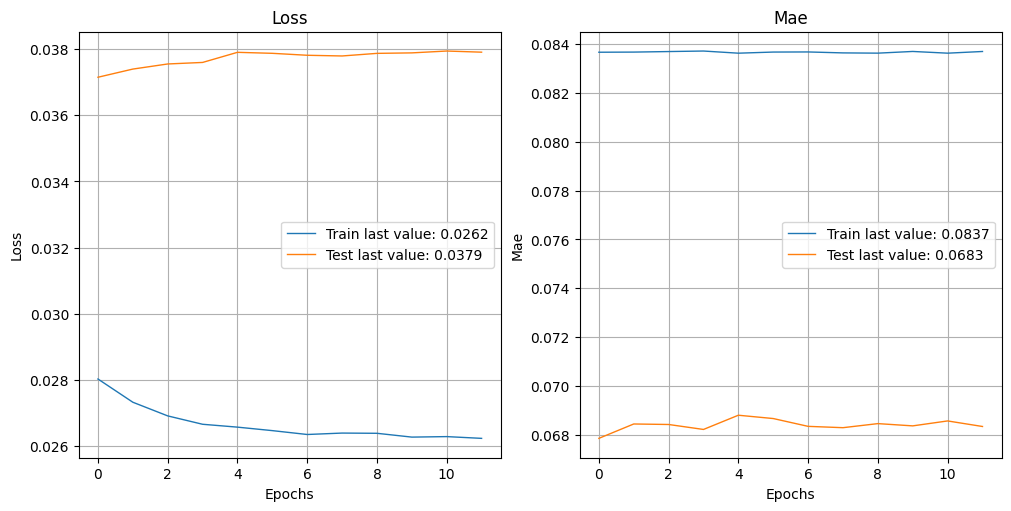

In [71]:
from plot_keras_history import show_history
show_history(fit_NN_stack)

The performance of the ensemble is again disappointing: the learning curve is flat, hence the rounds of back-propagation are useless. The training adds little value which means that the new overarching layer of ML does not enhance the original predictions. Again, this is because all ML engines seem to be capturing the same patterns and both their linear and non-linear combinations fail to improve their performance.

## Extensions

### Exogeneous Variables

In a financial context, macro-economic indicators could add value to the process. It's possible some models can perform better by introducing a flavor of **economic-driven conditionality** in the predictions.

Adding macro-variables to the set of predictors (here, predictions) $\tilde{y}_{i,m}$ could seem like one way to achieve this. However, this would amount to mix predicted values with (possibly scaled) economic indicators, which would not make much sense.

One alternative outside the perimeter of ensembles is to train *simple trees* on a set of macro-economic indicators. If the labels are the (possibly absolute) errors stemming from the original predictions, then the trees will create clusters of homogeneous error values. This will hint towards which conditions lead to best or worst forecasts.

We will test this idea below using aggregate data from the Federal Reserve of Saint Louis. A simple downloader in Python is the `pandas_datareader` package and we download and format the data next. `CPIAUCSL` is a code for consumer price index and `T10Y2YM` is a code for the term spread (10Y minus 2Y).

In [81]:
import pandas_datareader as pdr
fred_df = pdr.DataReader(['CPIAUCSL','T10Y2YM'], 'fred', "2010-01-01", "2021-12-31")
fred_df['inflation'] = fred_df['CPIAUCSL'] / fred_df['CPIAUCSL'].shift(1) - 1
fred_df = fred_df.rename(columns={'T10Y2YM': 'termspread'})
fred_df

,CPIAUCSL,termspread,inflation
DATE,,,
2010-01-01,217.488,2.80,NaN
2010-02-01,217.281,2.83,-0.000952
2010-03-01,217.353,2.77,0.000331
2010-04-01,217.403,2.79,0.000230
2010-05-01,217.290,2.59,-0.000520
...,...,...,...
2021-08-01,272.870,1.06,0.004070
2021-09-01,274.028,1.13,0.004244
2021-10-01,276.522,1.19,0.009101


In [99]:
# The first day of the month
test_sample['Index'] = test_sample['date'].apply(lambda x: x + pd.DateOffset(days=1) + pd.DateOffset(months=-1))

ens_data = pd.merge(test_sample[['date', 'Index']], fred_df, left_on='Index', right_index=True, how='left')
ens_data['err_NN_test'] = err_NN_test
ens_data

C:\Users\SamuelZhang\AppData\Local\Temp\ipykernel_43564\3905439756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['Index'] = test_sample['date'].apply(lambda x: x + pd.DateOffset(days=1) + pd.DateOffset(months=-1))


,date,Index,CPIAUCSL,termspread,inflation,err_NN_test
168,2014-01-31,2014-01-01,235.288,2.47,0.002424,-0.162756
169,2014-02-28,2014-02-01,235.547,2.38,0.001101,0.061890
170,2014-03-31,2014-03-01,236.028,2.32,0.002042,-0.025036
171,2014-04-30,2014-04-01,236.468,2.29,0.001864,-0.095926
172,2014-05-31,2014-05-01,236.918,2.17,0.001903,-0.092876
...,...,...,...,...,...,...
268331,2018-08-31,2018-08-01,251.663,0.25,0.001787,-0.044632
268332,2018-09-30,2018-09-01,252.182,0.23,0.002062,0.264800
268333,2018-10-31,2018-10-01,252.772,0.29,0.002340,-0.014334
268334,2018-11-30,2018-11-01,252.594,0.26,-0.000704,0.128499


We can now build a tree that tries to explain the accuracy of models as a function of macro-variables.

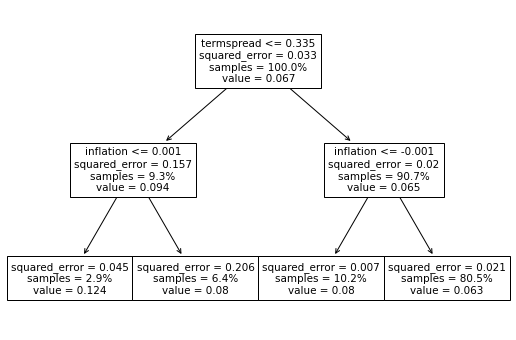

In [115]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

fit_ens = DecisionTreeRegressor(ccp_alpha=0.00001, max_depth=2)
fit_ens.fit(ens_data[['inflation', 'termspread']], ens_data['err_NN_test'].abs())
plt.figure(figsize=(9, 6))
plot_tree(fit_ens, feature_names=['inflation', 'termspread'], proportion=True)
plt.show()

The tree creates clusters with homogeneous values of absolute errors. One big cluster gathers 80.5% of the predictions (the rightmost one) and is the one with the smallest average. It corresponds to the periods when the termspread is greater than 0.335 (in percentage points). 
The second layers of splits are determined according to the level of inflation. If the latter smaller than 0.001, the mean absolute error is about 12%. If not, the value is about 8%.

This indicates that when the term spread is low and inflation negative, the model's predictions are not trustworthy because their errors have a magnitude twice as large as in other methods. Under these circumstances (which seem to be linked to a dire economic enviornment), it may be wiser not to use ML-based forecasts.

### Shrinking Inter-model Correlations

As shown earlier, a major problem with ensembles arises when the first layer of predictions is *highly correlated*. There are several tricks to help reduce this correlation, but the simplest and the best is probably to *alter training samples*. If algorithms do not see the same data, they will probably infer different patterns.

There are several ways to split the training data for different subsets of training samples.
- Random splits: easy and require only the target sample size to be fixed. If the original sample has $I$ instance and the ensemble requires $M$ models, then a subsample size of $\lfloor I/M \rfloor$ may be too conservative especially if the training sample is not very large. In this case, $\lfloor I/\sqrt{M} \rfloor$ may be a better alternative. Random forests are one example of ensembles built in random training samples.
- Deterministic splits: easy to reproduce and their outcome does not depend on the random seed. By the nature of *factor-based* training samples, we may split between *time and assets*.
  - Split in assets: train each model on a different set of stocks (randomly splitted or by some factor-based criterion, e.g., size, momentum, book-to-market ratio, etc.)
  - Split in dates: each model may stand for a particular kind of market condition.
  
Below we train 4 models on 4 different years to see if this helps reduce the inter-model correlations. Note that the third sample works on the small subset of features, hence the sample is smaller.

In [123]:
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

training_sample_2007 = training_sample[(training_sample.date >= '2007-01-01') & (training_sample.date <= '2007-12-31')]
training_sample_2009 = training_sample[(training_sample.date >= '2009-01-01') & (training_sample.date <= '2009-12-31')]
training_sample_2011 = training_sample[(training_sample.date >= '2011-01-01') & (training_sample.date <= '2011-12-31')][features_short + ['R1M_Usd']]
training_sample_2013 = training_sample[(training_sample.date >= '2013-01-01') & (training_sample.date <= '2013-12-31')]

Then, we proceed to the training of the models. We start with a penalized regression. In all predictions below, the original testing sample is used *for all models*.

In [120]:
from sklearn.linear_model import ElasticNet

y_ens_2007 = training_sample_2007['R1M_Usd']
x_ens_2007 = training_sample_2007[features]
fit_ens_2007 = ElasticNet(alpha = 0.1, l1_ratio = 0.1).fit(x_ens_2007, y_ens_2007)
err_ens_2007 = fit_ens_2007.predict(test_sample[features]) - test_sample['R1M_Usd']

We continue with a random forest.

In [121]:
from sklearn.ensemble import RandomForestRegressor

fit_ens_2009 = RandomForestRegressor(max_samples=4000, bootstrap=True,
                                     n_estimators=40, max_features=30,
                                     min_samples_leaf=100)
fit_ens_2009.fit(training_sample_2009[features], training_sample_2009['R1M_Usd'])
err_ens_2009 = fit_ens_2009.predict(test_sample[features]) - test_sample['R1M_Usd']

The third model is a boosted tree.

In [125]:
from xgboost import XGBRegressor

fit_ens_2011 = XGBRegressor(learning_rate = 0.4, 
                            objective = 'reg:squarederror',
                            max_depth = 4,
                            n_estimators = 18)
fit_ens_2011.fit(training_sample_2011[features_short], training_sample_2011['R1M_Usd'])
err_ens_2011 = fit_ens_2011.predict(test_sample[features_short]) - test_sample['R1M_Usd']

Finally, the last model is a simple neural network.

In [128]:
K.clear_session()
input_layer = Input((training_sample_2013[features].shape[1], ))
x = input_layer
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='tanh')(x)
x = Dense(1)(x)
output_layer = x
model_ens_2013 = Model(input_layer, output_layer)
model_ens_2013.compile(
    loss='mse',
    optimizer='RMSprop',
    metrics=['mae']
)
model_ens_2013.fit(
    training_sample_2013[features], training_sample_2013['R1M_Usd'],
    epochs = 9, batch_size = 512,
    verbose = 0
)

In [130]:
err_ens_2013 = model_ens_2013.predict(test_sample[features]).reshape((1, -1))[0] - test_sample['R1M_Usd']

2194/2194 [==============================] - 2s 952us/step


In [132]:
E_subtraining = pd.DataFrame([err_ens_2007, err_ens_2009, err_ens_2011, err_ens_2013], 
                             index=['err_ens_2007', 'err_ens_2009', 'err_ens_2011', 'err_ens_2013']).T
E_subtraining.corr()

,err_ens_2007,err_ens_2009,err_ens_2011,err_ens_2013
err_ens_2007,1.000000,0.980763,0.646009,0.999284
err_ens_2009,0.980763,1.000000,0.641003,0.983698
err_ens_2011,0.646009,0.641003,1.000000,0.646517
err_ens_2013,0.999284,0.983698,0.646517,1.000000


The results are overall disappointing. Only one model manages to extract patterns that are somewhat different from the other ones, resulting in a 65% correlation across the board. Neural networks (on 2013 data) and penalized regressions (2007) remain highly correlated. One possible explanation could be that the models capture mainly noise and little signal. Working with *long-term labels* like annual returns could help improve diversification across models.

## Exercise

Build an integrated ensemble on top of 3 neural networks trained entirely with Keras. Each network obtains one third of predictors as input. The three networks yield a classification (yes/no or buy/sell). The overarching network aggregates the three outputs into a final decision. Evaluate its performance on the testing sample. Use the functional API.

In [140]:
training_features_1 = training_sample[features[:len(features) // 3]]
training_features_2 = training_sample[features[len(features) // 3:len(features) // 3 * 2]]
training_features_3 = training_sample[features[len(features) // 3 * 2:]]

test_features_1 = test_sample[features[:len(features) // 3]]
test_features_2 = test_sample[features[len(features) // 3:len(features) // 3 * 2]]
test_features_3 = test_sample[features[len(features) // 3 * 2:]]

In [150]:
from keras.layers import Dense, Flatten, Input, Concatenate
from keras import Model
import keras.backend as K

K.clear_session()
input_layer_1 = Input((training_features_1.shape[1], ))
x_1 = input_layer_1
x_1 = Dense(16, activation='relu')(x_1)
x_1 = Dense(8, activation='relu')(x_1)
x_1 = Dense(2, activation='softmax')(x_1)

input_layer_2 = Input((training_features_2.shape[1], ))
x_2 = input_layer_2
x_2 = Dense(16, activation='relu')(x_2)
x_2 = Dense(8, activation='relu')(x_2)
x_2 = Dense(2, activation='softmax')(x_2)

input_layer_3 = Input((training_features_3.shape[1], ))
x_3 = input_layer_3
x_3 = Dense(16, activation='relu')(x_3)
x_3 = Dense(8, activation='relu')(x_3)
x_3 = Dense(2, activation='softmax')(x_3)

layer_concatenate = Concatenate()([x_1, x_2, x_3])
output_layer = Dense(2, activation='softmax')(layer_concatenate)
model_ens_exercise = Model([input_layer_1, input_layer_2, input_layer_3], output_layer)
model_ens_exercise.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           512         ['input_1[0][0]']                
                                                                                              

In [151]:
from keras.utils import to_categorical
model_ens_exercise.compile(
    loss='categorical_crossentropy', # classification task
    optimizer='Adam',
    metrics=['accuracy'] # use accuracy as a metric
)

NN_train_labels = to_categorical(training_sample['R1M_Usd_C'])
NN_test_labels = to_categorical(test_sample['R1M_Usd_C'])
fit_NN_exercise = model_ens_exercise.fit(
    [training_features_1, training_features_2, training_features_3], NN_train_labels,
    epochs = 10, batch_size = 512,
    validation_data=([test_features_1, test_features_2, test_features_3], NN_test_labels)
)

Epoch 1/10
387/387 [==============================] - 2s 5ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6938 - val_accuracy: 0.4997
Epoch 2/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6925 - accuracy: 0.5139 - val_loss: 0.6943 - val_accuracy: 0.4952
Epoch 3/10
387/387 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.5160 - val_loss: 0.6943 - val_accuracy: 0.4943
Epoch 4/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6918 - accuracy: 0.5192 - val_loss: 0.6943 - val_accuracy: 0.4969
Epoch 5/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6916 - accuracy: 0.5213 - val_loss: 0.6943 - val_accuracy: 0.5008
Epoch 6/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6914 - accuracy: 0.5234 - val_loss: 0.6951 - val_accuracy: 0.4989
Epoch 7/10
387/387 [==============================] - 2s 4ms/step - loss: 0.6913 - accuracy: 0.5239 - val_loss: 0.6947 - val_accuracy: 0.4991
Epoch 

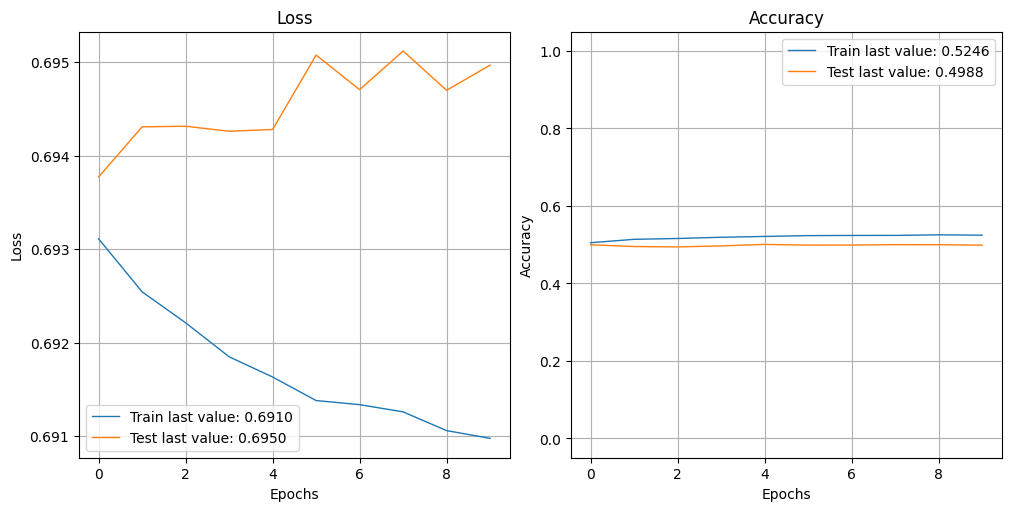

In [153]:
from plot_keras_history import show_history
show_history(fit_NN_exercise)

The result is also disappointing since the validation accuracy literally does not improve from random guess.

## Takeaways

Model ensembles: an "aggregation" or "averaging" of models and predictions, **combination** of algorithms

- Linear Ensembles
  - Minimizing the total (squared) error with a linear combination of the predictions from multiple models
  - Problem arises when the predictions are highly correlated: models *arbitrages* from each other
  - One improvement: enforce positivity constraints on the model weights
- Stacked Ensembles
  - Generalization for linear ensembles
  - Train a learner $h$ on the predictions of the previous models
- Extensions
  - Exogeneous variables: use macro-variables to tell under what circumstances ensembles are useful
  - Shrinking inter-model correlations: split training samples (according to dates or features)